### Dalciana B. Waller

## Credit card fraud detection

https://www.kaggle.com/mlg-ulb/creditcardfraud

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.  
The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. 
Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data.

- Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


<div class="alert alert-block alert-info">

### Load packages
</div>


In [4]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

C:\Users\Dalciana\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [5]:
import xgboost as xgb

C:\Users\Dalciana\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [6]:

from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import gc
"""
gc – Garbage Collector. 
gc exposes the underlying memory management mechanism of Python, 
the automatic garbage collector. 
The module includes functions for controlling how the collector operates 
and to examine the objects known to the system, 
either pending collection or stuck in reference cycles and unable to be freed ...
"""


'\ngc – Garbage Collector. \ngc exposes the underlying memory management mechanism of Python, \nthe automatic garbage collector. \nThe module includes functions for controlling how the collector operates \nand to examine the objects known to the system, \neither pending collection or stuck in reference cycles and unable to be freed ...\n'



<div class="alert alert-block alert-info">

## Read & Check data
</div>


In [7]:
#pd.set_option('display.max_columns', 100)

PATH=r'C:\Users\Dalciana\Python_DBW_files\304_Projeto_04_Fraud_detection'
data_df = pd.read_csv(PATH+"\creditcard.csv")

data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
"""
Let's  describe data.
Since all features are numerical, we can use directly command describe from pandas.
"""

data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
"""
Time range of measures in the dataset, in hours
"""
data_df['Time'].max()/3600 # Span of data occurences, in hours

47.99777777777778

### Checking missing data

In [10]:
total = data_df.isnull().sum().sort_values(ascending = False)
total

Class     0
V14       0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V15       0
Amount    0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Time      0
dtype: int64

In [11]:
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)

pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()


,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data.


## Check data unbalance

Related to target class  ( 0=not fraud, 1=fraud)


In [12]:
temp = data_df["Class"].value_counts()
temp

0    284315
1       492
Name: Class, dtype: int64

In [13]:
df = pd.DataFrame({'Class': temp.index,'values': temp.values})
df

,Class,values
0,0,284315
1,1,492


In [14]:
df['percentage']=df['values']/df.values.sum()
df.head()

,Class,values,percentage
0,0,284315,0.998269
1,1,492,0.001727


In [15]:
df.style.format({'percentage': "{:.2%}"})

,Class,values,percentage
0,0,284315,99.83%
1,1,492,0.17%


In [16]:
# using go from Ploty
trace = go.Bar(
    x = df['Class'],
    y = df['values'],
    text=df['percentage'],#text=df['values']
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Blue"),
    textposition='auto'
)

data1 = [trace]
layout1 = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',
              width=600
         )

fig = dict(data=data1, layout=layout1)

iplot(fig, filename='class')

Only 0.172% of data is Class=1. That means the data is highly unbalanced with respect with target variable Class.

This unbalance in the dataset makes sense because most part of the transactions are indeednot fraudulent.






<div class="alert alert-block alert-info">

## Data Exploration
</div>

###  Transactions in time


In [17]:
data_df['Time-hours']=data_df['Time']/3600 #delta related to first data of dataset
#data_df.style.format({'Time-hours': "{:.15f}"})
#data_df.drop(['Time-hours'],axis=1)
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time-hours
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556


In [15]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time-hours
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556


In [18]:
class_0 = data_df.loc[data_df['Class'] == 0]['Time']   # Type=series
class_1 = data_df.loc[data_df['Class'] == 1]['Time']

hist_data = [class_0, class_1]  #list
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, 
                         group_labels, 
                         show_hist=False, 
                         show_rug=False)

fig['layout'].update(title='Credit Card Transactions Time Density Plot', 
                     xaxis=dict(title='Time* [s]  *related to 1st transaction'))

iplot(fig, filename='dist_only')

In [19]:
"""
Let's see the plot considering hours (better visualize span)
"""

class_0 = data_df.loc[data_df['Class'] == 0]['Time-hours']   # Type=series
class_1 = data_df.loc[data_df['Class'] == 1]['Time-hours']

hist_data = [class_0, class_1]  #list
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, 
                         group_labels, 
                         show_hist=False, 
                         show_rug=False)

fig['layout'].update(title='Credit Card Transactions Time Density Plot', 
                     xaxis=dict(title='Time [h]  *related to 1st transaction'))

iplot(fig, filename='dist_only')

Here we see the distribution in a 48h span.

Valid (ie Non-fraudulent) transactions have valleys probably due to low in transaction amounts during the night.

Fraudulent transactions have a distribution more even than valid transactions.

## Transactions amount

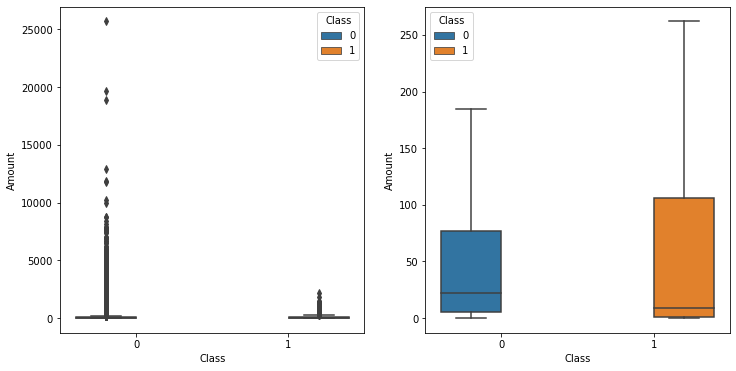

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                               figsize=(12,6))

s = sns.boxplot(ax = ax1,
                x="Class",y="Amount",
                data=data_df,
                hue="Class", 
                #palette="Paired_r",
                showfliers=True)

s = sns.boxplot(ax = ax2, 
                x="Class", y="Amount", 
                data=data_df,
                hue="Class", 
                #palette="Paired_r",
                showfliers=False)

plt.show();

In [21]:
dftmp = data_df[['Amount','Class']].copy()

class_0 = dftmp.loc[dftmp['Class'] == 0]['Amount']
class_1 = dftmp.loc[dftmp['Class'] == 1]['Amount']


"""
Statistics amount for Class label=0 (Valid)
"""

class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [22]:
"""
Statistics amount for Class label=1 (Fraudulent)
"""

class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Fraudulent transactions have a higher mean value but a smaller median (50th percentile) than a valid transaction. So the distributions is very skewd.
It means that most part of fraudulent transactions have smaller values, but the ones above makes the mean 

Let's plot the fraudulent transactions (amount) against time. 
The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [20]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(x = fraud['Time'],
                   y = fraud['Amount'],
                   name="Amount",
                   marker=dict(color='rgb(238,23,11)',
                               line=dict(color='red',
                                         width=1),
                               opacity=0.5,
                              ),
                   text= fraud['Amount'],
                   mode = "markers"
                  )

data = [trace]

layout = dict(title = 'Amount of fraudulent transactions',
              xaxis = dict(title = 'Time [s]', showticklabels=True), 
              yaxis = dict(title = 'Amount'),
              hovermode='closest'
             )

fig = dict(data=data, layout=layout)

iplot(fig, filename='fraud-amount')

<Figure size 432x288 with 0 Axes>

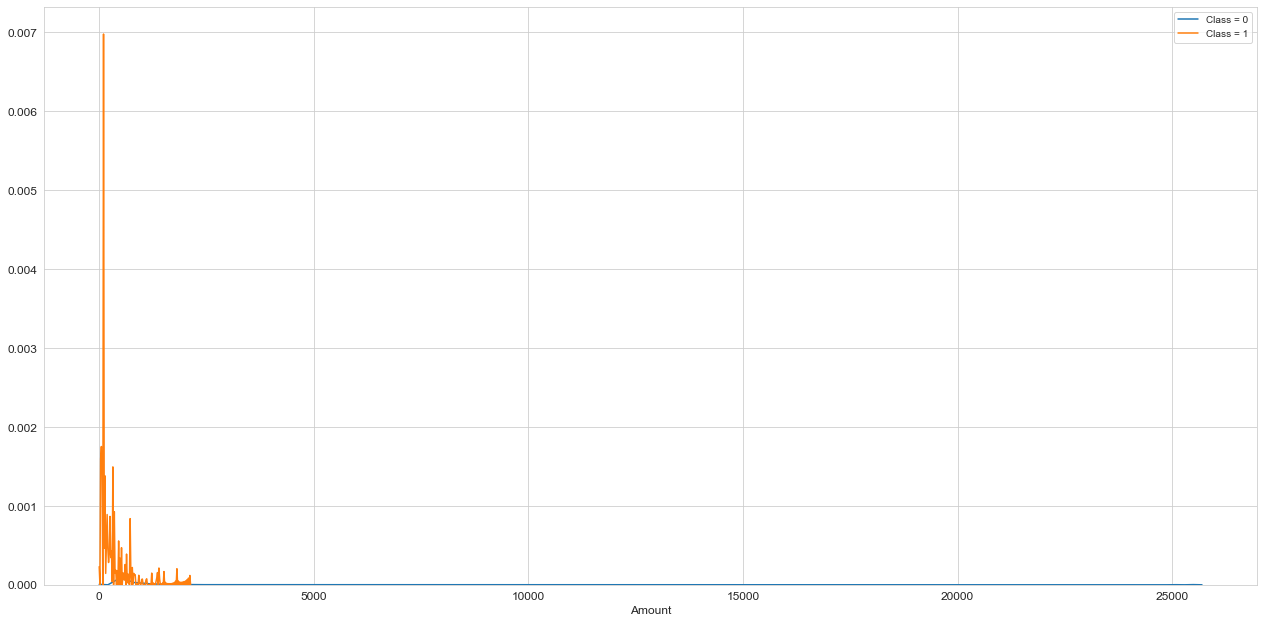

In [34]:
var = ['Amount'] #data_df.Amount.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,1,figsize=(100,100))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

## Features correlation

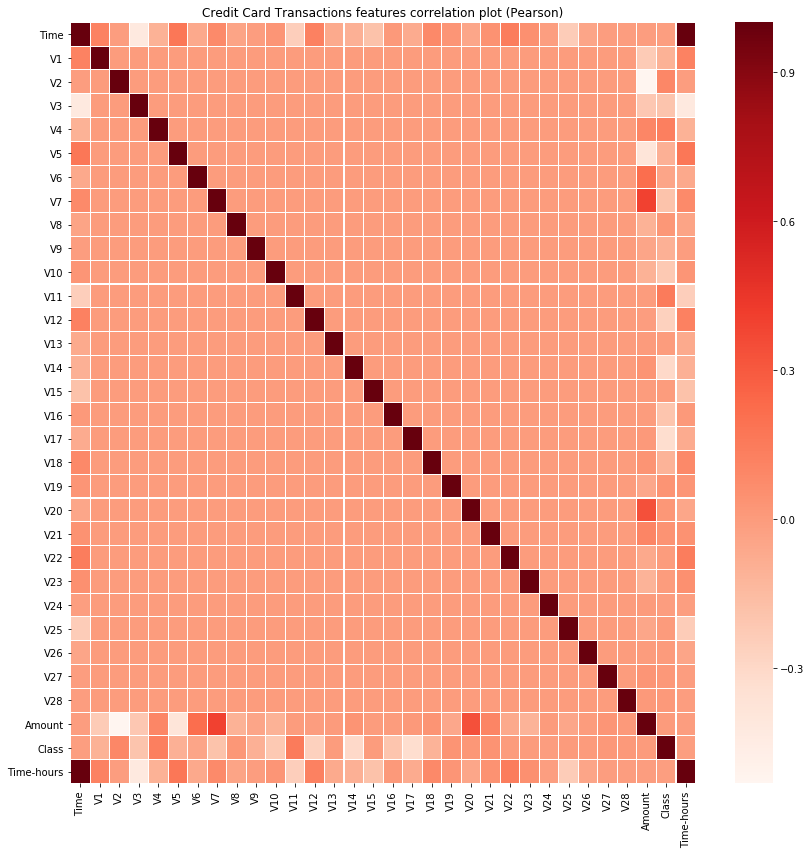

In [24]:
plt.figure(figsize = (14,14))

plt.title('Credit Card Transactions features correlation plot (Pearson)')

corr = data_df.corr()

sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            linewidths=.1,
            cmap="Reds")
plt.show()

As expected, there is no notable correlation between features V1-V28 (which are unknown).
Time and Time-hours are the same variable (only in another scale, so obvisously corr=1.

There are certain correlations between some of these features:
 - Time: inverse correlation with V3   
 
 - Amount:  - direct correlation with V7 and V20, inverse correlation with V2 and V5).

For the amount: Let's plot the correlated and inverse correlated values on the same graph.


1) Direct correlated values: V20 x Amount and  V7 x Amount.

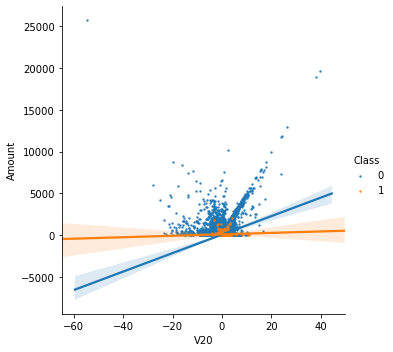

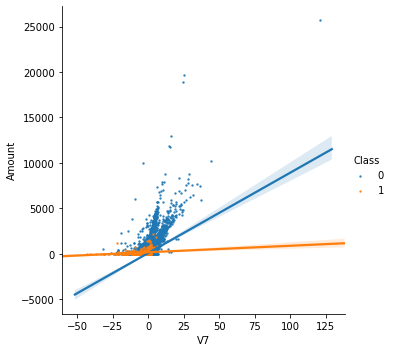

In [25]:
s = sns.lmplot(x='V20', 
               y='Amount',
               data=data_df, 
               hue='Class', fit_reg=True,scatter_kws={'s':2})

s = sns.lmplot(x='V7',
               y='Amount',
               data=data_df, 
               hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).

Let's plot now the inverse correlated values.

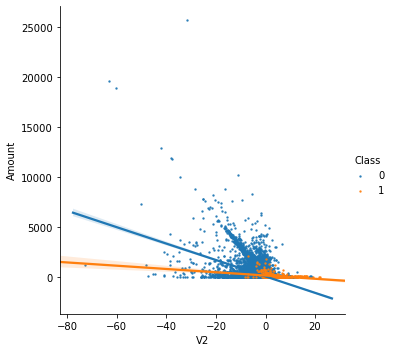

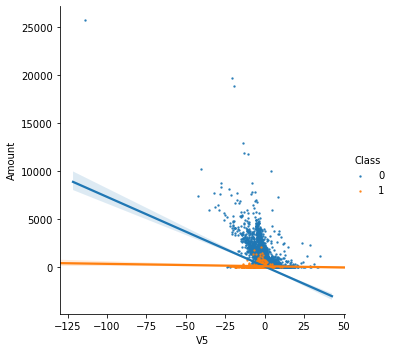

In [26]:
s = sns.lmplot(x='V2', 
               y='Amount',
               data=data_df, 
               hue='Class', fit_reg=True,scatter_kws={'s':2})

s = sns.lmplot(x='V5',
               y='Amount',
               data=data_df, 
               hue='Class', 
               fit_reg=True,scatter_kws={'s':2})
plt.show()


Indeed,  the two couples of features are inverse correlated, and the regression line of class=0 have a higher negative slope.




## Features density plot

<Figure size 432x288 with 0 Axes>

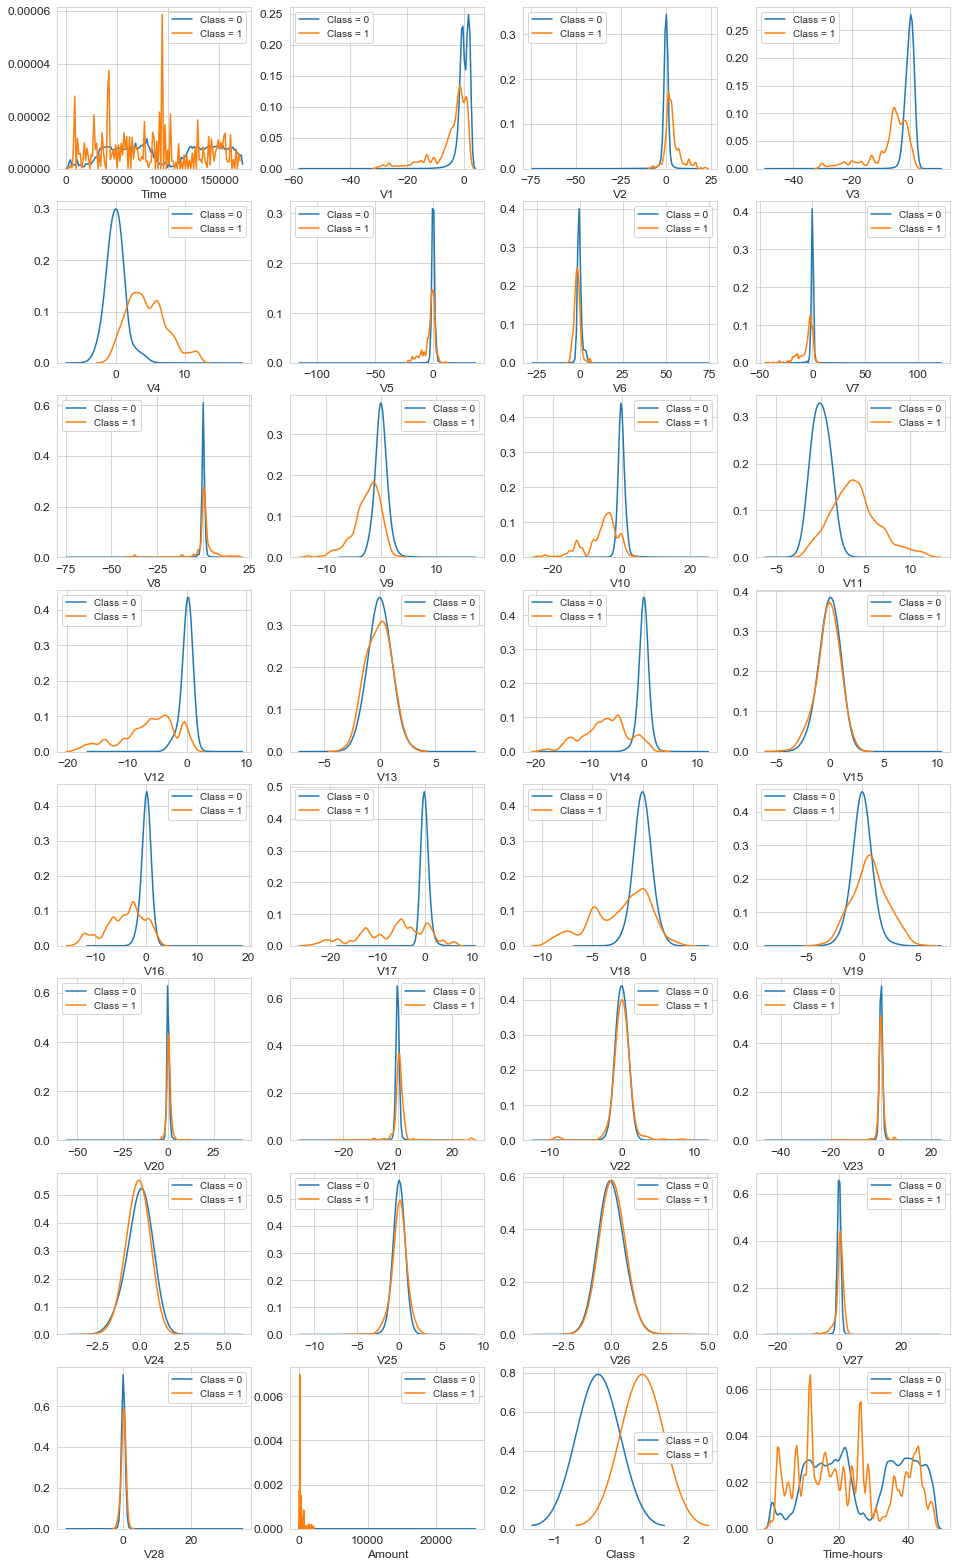

In [27]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();


For some of the features we can observe a good selectivity in terms of distribution for the two values of Class:
 - V4, V11 have clearly separated distributions for Class values 0 and 1, 
 - V12, V14, V18 are partially separated,  
 - V1, V2, V3, V10 have a quite distinct profile,
 - V25, V26, V28 have similar profiles for the two values of Class. 

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. 

In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.




<div class="alert alert-block alert-info">

## Predictive models
</div>

Define predictors and target values
Let's define the predictor features and the target features. 
There is no Categorical features.

In [25]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [21]:
"""
Define some parameters for the predictive steps
"""

#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split


#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

# Metrics for RandomForrestClassifier
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

### Split data in train, test and validation set
Let's define train, validation and test sets.

In [22]:
# split for [ train+valid]  and test data
train_df, test_df = train_test_split(data_df,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE,
                                     shuffle=True )

#take the 80% remaining to split again betweeen train and validation data (20% of the 80% reamining):
train_df, valid_df = train_test_split(train_df, 
                                      test_size=VALID_SIZE,
                                      random_state=RANDOM_STATE, 
                                      shuffle=True )

In [23]:
print(train_df.size)
print(valid_df.size)
print(test_df.size)


5832832
1458208
1822784


Let's start with a RandomForrestClassifier [3] model.

### 1)  RandomForestClassifier

Obs.: To use DEcision trees and Random forests algorithms , it is not required to rescale data.



#### 1) Define model parameters

Let's run a model using the training set.

We will use as validation criterion GINI,  which formula is GINI = 2 * (AUC) - 1,  
where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC) [4]. 
 
Number of estimators is set to 100 and number of parallel jobs is set to 4.

We start by initializing the RandomForestClassifier.

In [24]:
clf_rf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)



#### 2) Train & Prediction

In [49]:
"""
Let's train the RandomForestClassifier using the train_df data and fit function.
"""
clf_rf.fit(train_df[predictors], train_df[target].values)


"""
Let's now predict the target values for the valid_df data, using predict function.
"""
pred_rf = clf_rf.predict(valid_df[predictors])

Let's also visualize the features importance.

#### Features importance

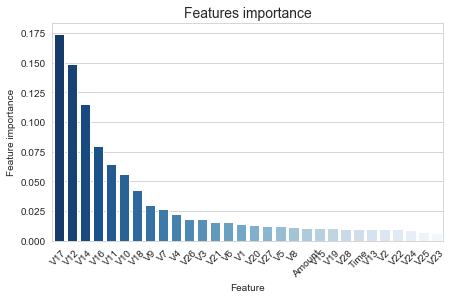

In [62]:
tmp = pd.DataFrame({'Feature': predictors, 
                    'Feature importance': clf_rf.feature_importances_})

tmp = tmp.sort_values(by='Feature importance',ascending=False)

plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)

s = sns.barplot(x='Feature',
                y='Feature importance',
                palette='Blues_r',
                data=tmp)

s.set_xticklabels(s.get_xticklabels(),
                  rotation=45)
plt.show()   

The most important features are V17, V12, V14, V10, V11, V16.

#### 3) Confusion matrix
Let's show a confusion matrix for the results we obtained.

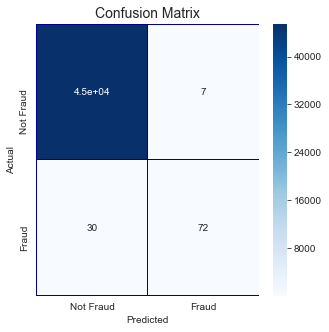

In [55]:
cm = pd.crosstab(valid_df[target].values,
                 pred_rf, 
                 rownames=['Actual'],
                 colnames=['Predicted'])

fig, (ax1) = plt.subplots(ncols=1, 
                          figsize=(5,5))

sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,
            linecolor="Darkblue",
            cmap="Blues")

plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Type I error and Type II error
We need to clarify that confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data,  because we will actually need a different metrics that accounts in the same time for the selectivity and specificity of the method we are using, so that we minimize in the same time both Type I errors and Type II errors.


##### Null hypothesis testing is a formal approach to deciding between two interpretations of a statistical relationship in a sample.   
One interpretation is called the null hypothesis (often symbolized H0 and read as “H-naught”
Null hypothesis is usually the most accepted hypothesis 


Null Hypothesis (H0) - The transaction is not a fraud.   (Class=0)
Alternative Hypothesis (H1) - The transaction is a fraud. (Class=1)

- Type I error (or significance level*) - You reject the null hypothesis when the null hypothesis is actually true.
- Type II error - You fail to reject the null hypothesis when the the alternative hypothesis is true.

- Cost of Type I error - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.
- Cost of Type II error - You erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted.


*significance level is denoted as α (alpha), also called the alpha level. Usually, the significance level is set to 0.05 (5%), implying that it is acceptable to have a 5% probability of incorrectly rejecting the true null hypothesis


The following image explains what Type I error and Type II error are:
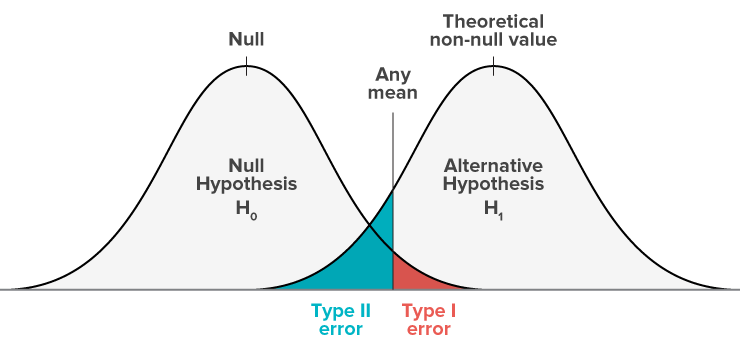

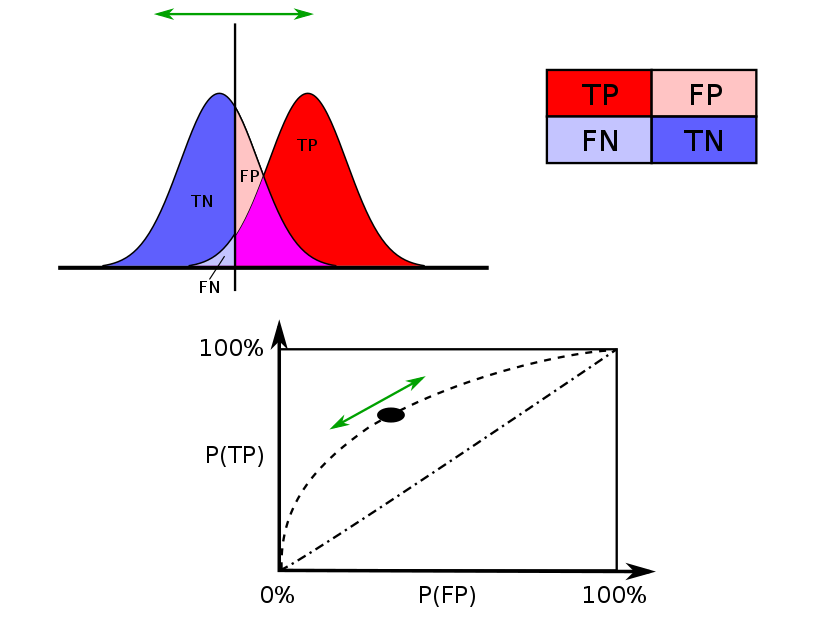

#### Let's calculate the ROC-AUC score [4].

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.

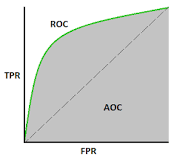
Area under curve

In [56]:
# ROC -AUC score for RandomForest
roc_auc_score(valid_df[target].values, pred_rf)

0.8528641975628091

### 2) AdaBoostClassifier 

#### Prepare & fit the model
Let's set the parameters for the model and initialize the model.

In [58]:
clf_ada = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

"""
Fit the model
"""

clf_ada.fit(train_df[predictors], train_df[target].values)


"""
Predict the target values
Let's now predict the target values for the valid_df data, using predict function.
"""

pred_ada = clf_ada.predict(valid_df[predictors])

#### Features importance

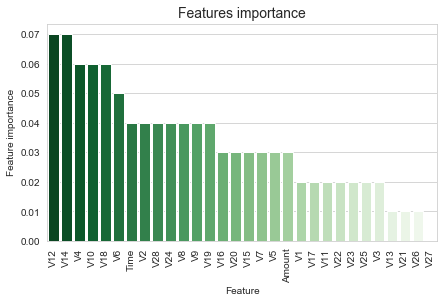

In [61]:


tmp = pd.DataFrame({'Feature': predictors, 
                    'Feature importance': clf_ada.feature_importances_})

tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)

s = sns.barplot(x='Feature',
                y='Feature importance',
                palette='Greens_r',
                data=tmp)

s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

#### Confusion matrix


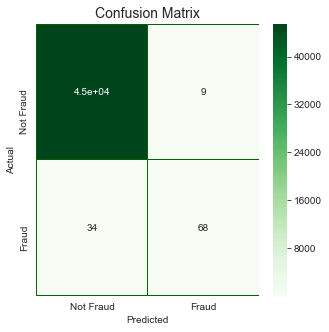

In [63]:
cm = pd.crosstab(valid_df[target].values, 
                 pred_ada, 
                 rownames=['Actual'], 
                 colnames=['Predicted'])

fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))

sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,
            linecolor="Darkgreen",
            cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#### ROC-AUC

In [65]:
roc_auc_score(valid_df[target].values, pred_ada)

0.8332343604519027

### 3) XGBoost
XGBoost is a gradient boosting algorithm.


#### Prepare &fit the model
We initialize the DMatrix objects for training and validation, starting from the datasets.  
We also set some of the parameters used for the model tuning.

In [26]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors],
                     train_df[target].values)

dvalid = xgb.DMatrix(valid_df[predictors], 
                     valid_df[target].values)

dtest = xgb.DMatrix(test_df[predictors], 
                    test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

#### Train the model

In [28]:
MAX_ROUNDSxg=3000

model_xg = xgb.train(params, 
                dtrain, 
                MAX_ROUNDSxg, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[23:00:12] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.89296	valid-auc:0.85272
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.93947	valid-auc:0.88200
[100]	train-auc:0.94415	valid-auc:0.89094
[150]	train-auc:0.97837	valid-auc:0.96362
[200]	train-auc:0.99002	valid-auc:0.98397
[250]	train-auc:0.99382	valid-auc:0.98592
[300]	train-auc:0.99567	valid-auc:0.98667
Stopping. Best iteration:
[282]	train-auc:0.99517	valid-auc:0.98706



#### Features importance

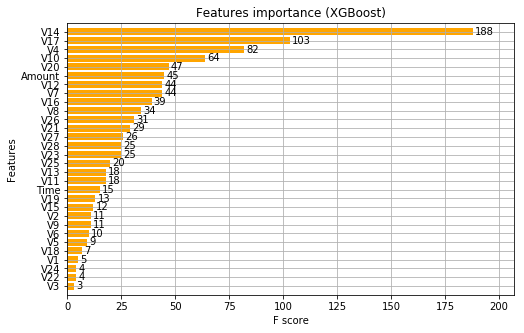

In [30]:

"""
Features importance
Let's see also the features importance.

"""
fig, (ax) = plt.subplots(ncols=1, 
                         figsize=(8,5))

xgb.plot_importance(model_xg, 
                    height=0.8, 
                    title="Features importance (XGBoost)", 
                    ax=ax,
                    color="orange") 
plt.show()

#### Predict test set
We used the train and validation sets for training and validation.
We will use the trained model now to predict the target value for the test set.

In [31]:
pred_xgb = model_xg.predict(dtest)

#### ROC-AUC.

In [32]:
roc_auc_score(test_df[target].values, pred_xgb)

0.9766700080897612

### 4) LightGBM


#### Define model parameters
Let's set the parameters for the model. We will use these parameters only for the first lgb model.

In [33]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

#### Prepare the model

Let's prepare the model, creating the Datasets data structures from the train and validation sets.

In [37]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

#### Run the model
Let's run the model, using the train function.

In [40]:
evals_results = {}

model_lgbm = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,   #max_rounds=1000
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.97289	valid's auc: 0.967126
[100]	train's auc: 0.987513	valid's auc: 0.972525
[150]	train's auc: 0.988872	valid's auc: 0.93531
Early stopping, best iteration is:
[85]	train's auc: 0.987093	valid's auc: 0.974528


Best validation score was obtained for round 85, for which AUC ~= 0.974.

####  Feature importance


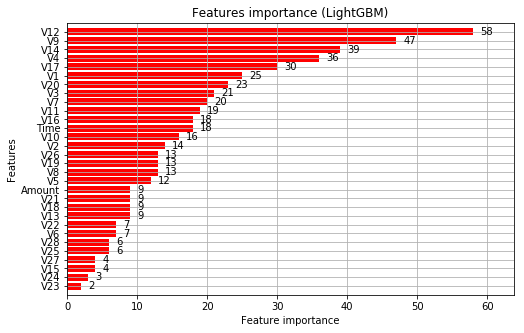

In [39]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))

lgb.plot_importance(model, 
                    height=0.8, 
                    title="Features importance (LightGBM)", 
                    ax=ax,
                    color="red") 
plt.show()

Let's predict now the target for the test data.

#### Predict test data

In [41]:
pred_lgbm = model_lgbm.predict(test_df[predictors])

#### Area under curve
Let's calculate the ROC-AUC score for the prediction.

In [43]:
roc_auc_score(test_df[target].values, pred_lgbm)

0.9459470296507333

### Training and validation using cross-validation
Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions

In [44]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])

test_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
n_fold = 0

In [46]:
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    
    model.fit(train_x, train_y, 
              eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', 
              verbose= VERBOSE_EVAL,
              early_stopping_rounds= EARLY_STOP)
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, 
                                               num_iteration=model.best_iteration_)[:, 1]
    
    test_preds += model.predict_proba(test_df[predictors],
                                      num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
    
    
    
    
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)           

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.962157	valid_1's auc: 0.989338
Early stopping, best iteration is:
[13]	training's auc: 0.968109	valid_1's auc: 0.99314
Fold  1 AUC : 0.993140
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.981643	valid_1's auc: 0.95593
Early stopping, best iteration is:
[10]	training's auc: 0.979098	valid_1's auc: 0.965326
Fold  2 AUC : 0.965326
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.979434	valid_1's auc: 0.943348
Early stopping, best iteration is:
[37]	training's auc: 0.981891	valid_1's auc: 0.945099
Fold  3 AUC : 0.945099
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.972729	valid_1's auc: 0.989338
[100]	training's auc: 0.97498	valid_1's auc: 0.994546
[150]	training's auc: 0.976713	valid_1's auc: 0.994725
Early stopping, best iteration is:
[118]	training's auc: 0.974884	valid_1's auc: 0.995364
Fold  4

In [47]:
train_auc_score

0.9309284495927501

The AUC score for the prediction from the test data was 0.93.

We prepare the test prediction, from the averaged predictions for test over the 5 folds.

In [48]:
pred = test_preds

### Conclusions

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. 

We then investigated two predictive models:  RandomForest(1), adaboost(2), XGBoost(3) and Lightgbm(4)
The data was split in 3 parts, a train set, a validation set and a test set. 

Feature importance was different for each of the models.
Based on the top 6 variables
 - V14 is the variable that appear as  high-priorty in all models is V14.
 - V12 is relevant in models (1),(2),(4)
 - V17 is relevant in models (1),(3),(4)
 - V10 is relevant in models (1),(2),(3),
 - V4 is relevant in models (2),(3),(4)  


The model that have the best predicted the possible occurence of a fraud transaction was XGBoost, based on AUR_ROC score.
